In [1]:
from __future__ import print_function
from builtins import super
"""
Implementation of Block Neural Autoregressive Flow
http://arxiv.org/abs/1904.04676
"""



import torch.nn.functional as F
import random
import torch
torch.set_printoptions(profile="full")
import copy
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as D
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import warnings
import torchvision
print ("torch",torch.__version__)
print ("torchvision",torchvision.__version__)
warnings.filterwarnings("ignore")

import sys
import array
import math
import os
import time
import argparse
import pprint
import scipy
from scipy import special
from functools import partial
import json
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
from tqdm import tqdm
np.set_printoptions(threshold=sys.maxsize)
from sklearn.manifold import TSNE
import csv
from torch.utils import data

from tqdm import trange





torch 1.8.1
torchvision 0.2.2


In [53]:
%matplotlib inline
# --------------------
# Data
# --------------------
#matplotlib.use('tkagg')
class sample:
    def __init__(self, nchan ,biasmag, batch_size, topred, seed=None):
        self.biasmag=biasmag
        self.batch_size=batch_size
        self.nchan=nchan
        self.seed=seed
        self.topred=topred
    def sreturn(self):
        xvals=[]
        yvals=[]
        ychan=[]
        if (self.seed==None):
                rng = np.random
        else:
                rng = np.random.RandomState(self.seed)
        #print (-1,1,(self.batch_size,self.nchan))
        randonarr=rng.uniform(-1,1,(self.batch_size,self.nchan))*self.biasmag
        #randonarr[:,1]=1.0*randonarr[:,0]+0.0*randonarr[:,1]


        ntimep = 100+self.topred
        for bb in range(self.batch_size):


                curx=[]
                cury=[]
                prevarrand=np.array([])
                perm=np.arange(4)
                np.random.shuffle(perm)
                #print(perm)
                ychan.append(perm)
                for nn in range(self.nchan):
                        sinfac=rng.uniform(0.1,1.2)*1.1
                        sinarr=np.sin(np.arange(ntimep)*sinfac)*1
                        cosfac=rng.uniform(0.1,1.2)*1.1
                        cosarr=np.cos(np.arange(ntimep)*cosfac)*1
                        #print(sinfac)
                        #print(cosfac)
                        corrnoise=False
                        arrand = rng.uniform(-1,1,ntimep)
                        if corrnoise:
                                if prevarrand.size==0:
                                        arrand = rng.uniform(-1,1,ntimep)
                                else:
                                        arrand = rng.uniform(-1,1,ntimep)
                                        arrand[nn*5:]=prevarrand[0:-1*nn*5]
                                cs=np.cumsum(arrand)
                        else:
                                arrand = rng.uniform(-1,1,ntimep)*0.0
                                cs=np.cumsum(arrand+randonarr[bb][nn])+sinarr+cosarr

                        #print (sinarr) 
                        curx.append(cs[:-self.topred])
                        cury.append(cs[-self.topred:])
                        #curx.append(np.cumsum(arrand+randonarr[bb][0]))
                        prevarrand=arrand
                curx=np.array(curx)
                cury=np.array(cury)
                #print (ychan[-1])
                #print (curx[:,0])

                curx=curx[ychan[-1]]
                #curx=np.transpose(curx,ychan[-1])
                #print (curx[:,0])
                #print ()
                cury=cury[ychan[-1]]
     
                xvals.append((curx))
                yvals.append((cury))
                #print (np.array(xvals).shape)
                #print (np.array(yvals).shape)
                #plt.plot(curx)
                #plt.xlabel("steps")
                #plt.ylabel("position")
                #plt.title("randdwalk")
                #plt.show()
                #sys.exit()
                #input("Press Enter to continue...")
        return np.array(xvals, dtype="float32"),np.array(yvals, dtype="float32"),np.array(ychan, dtype="int64")







In [54]:
def tspred(model,data,ntime):
        fdata=list(data)
        for itime in range(ntime):
            curpred=model(fdata)
            if (itime==0):
                preds = curpred
            else:
                preds = torch.cat((preds,curpred),dim=2)

            fdata[0]= torch.cat((fdata[0],curpred),dim=2)[:,:,1:]

        return preds

In [55]:

class LSTM(nn.Module):
    def __init__(self,nchan=4,ntime=100,n_hidden=128,n_layers=2,npoint=5):
        super(LSTM, self).__init__()
        self.n_hidden=n_hidden
        self.n_layers=n_layers
        self.ntime=ntime+npoint
        self.nchan=nchan
        self.npoint=npoint 
        self.output_size=self.nchan*self.npoint
        self.ks=10





        self.lin = nn.Sequential(  
        nn.Linear(464, 2*400)
        )
        self.out1 = nn.Linear(self.n_hidden, self.n_hidden)

        self.out = nn.Linear(self.n_hidden, self.output_size)


        self.lstm = nn.LSTM(input_size=nchan,hidden_size= self.n_hidden, num_layers=self.n_layers,batch_first=True)
        self.lstm1 = nn.LSTM(input_size=self.n_hidden,hidden_size= self.n_hidden, num_layers=self.n_layers,batch_first=True)
        
        #self.lstm1 = nn.LSTM(input_size=1,hidden_size= self.n_hidden, num_layers=self.n_layers,batch_first=True)
        #self.soft = nn.Sequential( nn.Softmax(dim=1))
        

    def forward(self, inputs):
        inputlstm=inputs
        inputlstmshape=inputlstm.shape
        batchs =inputlstmshape[0]
        #inputconv=inputs[1].unsqueeze(1).transpose(1, 2)


        #h0c = torch.zeros( self.n_layers, batchs, self.n_hidden).to('cuda')  
        #c0c = torch.zeros( self.n_layers, batchs, self.n_hidden).to('cuda')
        #LSc,hiddenc=self.lstm1(inputconv, (h0c,c0c)) 


        inputlstm=inputlstm.transpose(1, 2)

        #print(LSc.shape)
        #print(inputlstm.shape)
        h0 = torch.zeros( self.n_layers, batchs, self.n_hidden).to('cuda')  
        c0 = torch.zeros( self.n_layers, batchs, self.n_hidden).to('cuda')
        LS,hidden=self.lstm(inputlstm,(h0,c0))

        #LS,hidden=self.lstm1(LS,hidden)        
        #output = self.out(torch.cat((LS[:,-1,:],LSc[:,-1,:]),dim=1))
        LS=LS[:,-1,:].reshape(LS.size(0), -1)
        #output = F.relu(self.out1(LS))

        output = self.out(LS)
        #print (output.shape)


        return output.reshape(output.shape[0],self.nchan,self.npoint)



In [56]:

class Conv(nn.Module):
    def __init__(self,nchan=4,ntime=100,n_hidden=64,n_layers=1,npoint=5):
        super(Conv, self).__init__()
        self.n_hidden=n_hidden
        self.n_layers=n_layers
        self.ntime=ntime+npoint
        self.nchan=nchan
        self.npoint=npoint 
        self.output_size=self.nchan*self.npoint
        self.ks=10

        self.conv1 = nn.Sequential( 
            nn.Conv1d(self.nchan, self.n_hidden,kernel_size=10, padding=1),
            nn.MaxPool1d(2)
        )
        self.conv2 = nn.Sequential( 
            nn.Conv1d(self.n_hidden, self.n_hidden,stride=1, kernel_size=30, padding=1),
            nn.MaxPool1d(2)
        )

        self.lin = nn.Sequential(  
        nn.Linear(self.n_hidden*9, self.n_hidden)
        )

        self.out = nn.Linear(self.n_hidden, self.nchan*self.nchan)



    def forward(self, inputs):
        batchs =inputs.shape[0]
        CO = F.relu(self.conv1(inputs))  
        CO = F.relu(self.conv2(CO))  
        lin = F.relu(self.lin(CO.reshape(CO.size(0), -1)))

        output = F.softmax(self.out(lin))
        return output.reshape(inputs.shape[0],self.nchan,self.nchan),lin


Start step 0; Training for 50000 steps:   0%|                                     | 0/50000 [00:00<?, ?it/s, L=13.2084]

0.01
torch.Size([100, 4, 40])


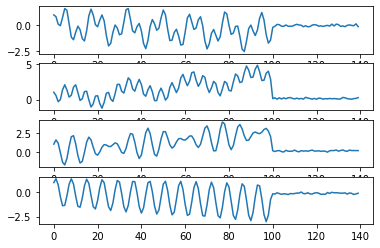

Start step 0; Training for 50000 steps:   0%|                            | 4/50000 [00:00<1:35:15,  8.75it/s, L=6.2973]

12473.5341796875


Start step 0; Training for 50000 steps:   5%|█▎                         | 2500/50000 [01:12<23:50, 33.20it/s, L=0.8056]

0.01
torch.Size([100, 4, 40])


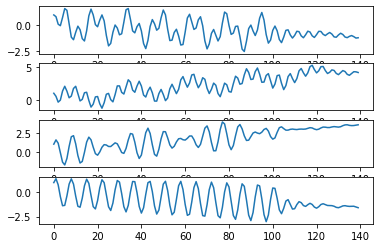

Start step 0; Training for 50000 steps:   5%|█▎                         | 2507/50000 [01:12<39:49, 19.87it/s, L=0.7870]

790.5052490234375


Start step 0; Training for 50000 steps:  10%|██▋                        | 5001/50000 [02:25<21:33, 34.78it/s, L=0.6264]

0.01
torch.Size([100, 4, 40])


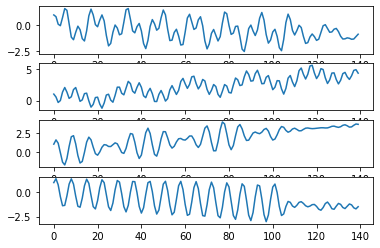

Start step 0; Training for 50000 steps:  10%|██▋                        | 5007/50000 [02:26<41:37, 18.02it/s, L=0.6234]

647.1467895507812


Start step 0; Training for 50000 steps:  15%|████                       | 7500/50000 [03:41<23:09, 30.58it/s, L=0.5149]

0.01
torch.Size([100, 4, 40])


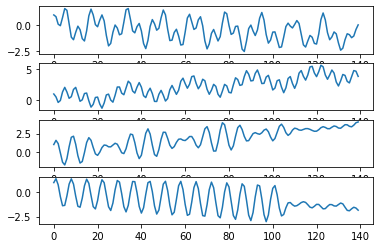

Start step 0; Training for 50000 steps:  15%|████                       | 7506/50000 [03:41<43:50, 16.15it/s, L=0.5217]

526.9426879882812


Start step 0; Training for 50000 steps:  20%|█████▏                    | 10001/50000 [04:52<18:35, 35.85it/s, L=0.4225]

0.01
torch.Size([100, 4, 40])


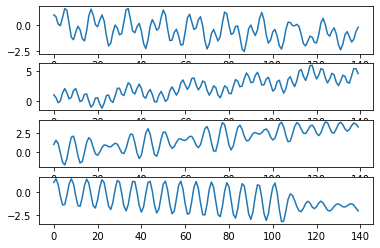

Start step 0; Training for 50000 steps:  20%|█████▏                    | 10007/50000 [04:52<36:32, 18.24it/s, L=0.4384]

432.91082763671875


Start step 0; Training for 50000 steps:  25%|██████▌                   | 12501/50000 [06:02<18:22, 34.00it/s, L=0.3743]

0.01
torch.Size([100, 4, 40])


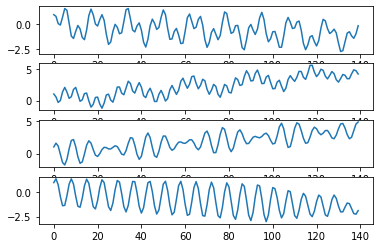

Start step 0; Training for 50000 steps:  25%|██████▌                   | 12507/50000 [06:03<34:30, 18.11it/s, L=0.3576]

352.8798522949219


Start step 0; Training for 50000 steps:  30%|███████▊                  | 15001/50000 [07:15<16:48, 34.69it/s, L=0.3040]

0.01
torch.Size([100, 4, 40])


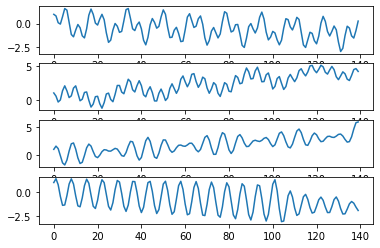

Start step 0; Training for 50000 steps:  30%|███████▊                  | 15007/50000 [07:15<30:49, 18.92it/s, L=0.3298]

288.71014404296875


Start step 0; Training for 50000 steps:  35%|█████████                 | 17501/50000 [08:27<15:29, 34.95it/s, L=0.2542]

0.01
torch.Size([100, 4, 40])


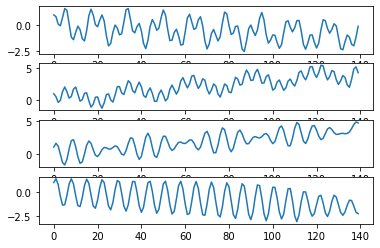

Start step 0; Training for 50000 steps:  35%|█████████                 | 17507/50000 [08:28<28:18, 19.13it/s, L=0.2416]

244.45950317382812


Start step 0; Training for 50000 steps:  40%|██████████▍               | 20001/50000 [09:39<14:17, 35.00it/s, L=0.2211]

0.01
torch.Size([100, 4, 40])


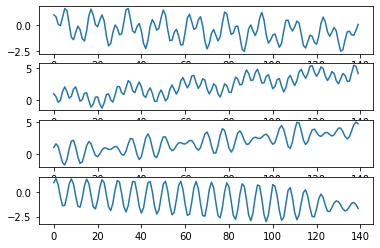

Start step 0; Training for 50000 steps:  40%|██████████▍               | 20007/50000 [09:40<26:06, 19.14it/s, L=0.2228]

209.5972442626953


Start step 0; Training for 50000 steps:  45%|███████████▋              | 22501/50000 [10:51<13:02, 35.13it/s, L=0.1797]

0.01
torch.Size([100, 4, 40])


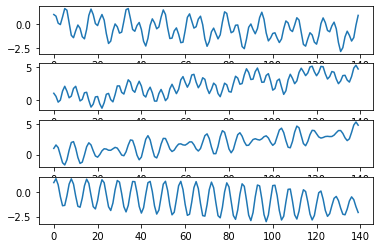

Start step 0; Training for 50000 steps:  45%|███████████▋              | 22507/50000 [10:52<26:07, 17.54it/s, L=0.1881]

183.66993713378906


Start step 0; Training for 50000 steps:  50%|█████████████             | 25001/50000 [12:03<12:01, 34.67it/s, L=0.1596]

0.01
torch.Size([100, 4, 40])


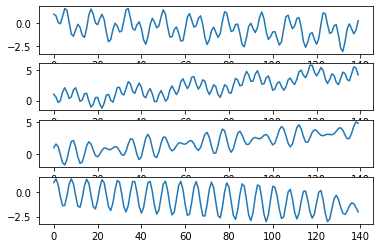

Start step 0; Training for 50000 steps:  50%|█████████████             | 25007/50000 [12:04<21:54, 19.02it/s, L=0.1641]

161.36412048339844


Start step 0; Training for 50000 steps:  55%|██████████████▎           | 27501/50000 [13:15<10:48, 34.71it/s, L=0.1402]

0.01
torch.Size([100, 4, 40])


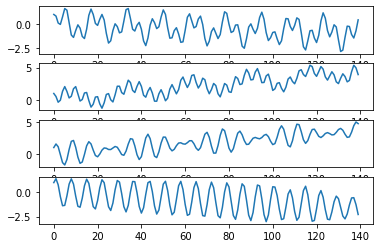

Start step 0; Training for 50000 steps:  55%|██████████████▎           | 27507/50000 [13:16<19:42, 19.03it/s, L=0.1287]

144.51651000976562


Start step 0; Training for 50000 steps:  60%|███████████████▌          | 30001/50000 [14:27<09:31, 35.02it/s, L=0.1148]

0.01
torch.Size([100, 4, 40])


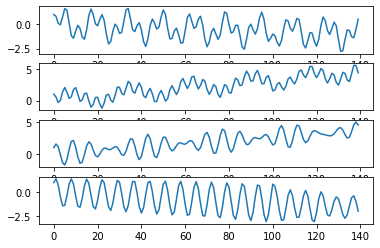

Start step 0; Training for 50000 steps:  60%|███████████████▌          | 30007/50000 [14:28<17:30, 19.04it/s, L=0.1237]

132.12460327148438


Start step 0; Training for 50000 steps:  65%|████████████████▉         | 32501/50000 [15:39<08:16, 35.28it/s, L=0.1140]

0.01
torch.Size([100, 4, 40])


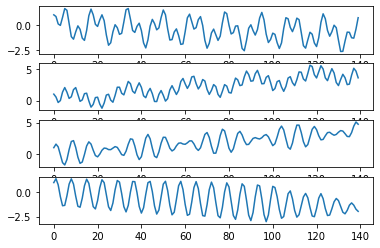

Start step 0; Training for 50000 steps:  65%|████████████████▉         | 32507/50000 [15:39<15:11, 19.20it/s, L=0.1139]

116.8729019165039


Start step 0; Training for 50000 steps:  70%|██████████████████▏       | 35001/50000 [16:51<07:08, 35.04it/s, L=0.0954]

0.01
torch.Size([100, 4, 40])


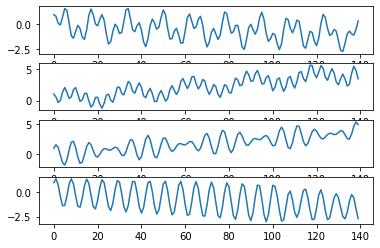

Start step 0; Training for 50000 steps:  70%|██████████████████▏       | 35007/50000 [16:51<13:05, 19.09it/s, L=0.0985]

106.83448028564453


Start step 0; Training for 50000 steps:  75%|███████████████████▌      | 37501/50000 [18:02<05:56, 35.04it/s, L=0.0880]

0.01
torch.Size([100, 4, 40])


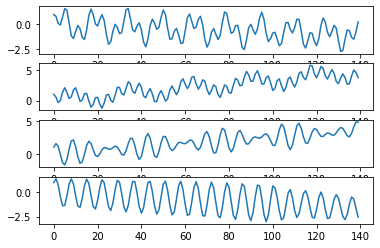

Start step 0; Training for 50000 steps:  75%|███████████████████▌      | 37507/50000 [18:03<11:36, 17.94it/s, L=0.0887]

93.89419555664062


Start step 0; Training for 50000 steps:  80%|████████████████████▊     | 40001/50000 [19:14<04:44, 35.11it/s, L=0.0946]

0.01
torch.Size([100, 4, 40])


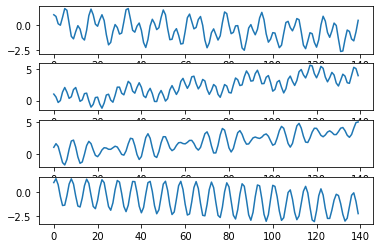

Start step 0; Training for 50000 steps:  80%|████████████████████▊     | 40007/50000 [19:15<08:41, 19.15it/s, L=0.0881]

86.13993835449219


Start step 0; Training for 50000 steps:  85%|██████████████████████    | 42501/50000 [20:26<03:33, 35.09it/s, L=0.0885]

0.01
torch.Size([100, 4, 40])


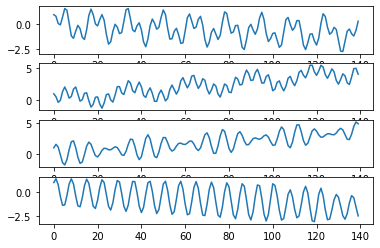

Start step 0; Training for 50000 steps:  85%|██████████████████████    | 42507/50000 [20:27<06:31, 19.13it/s, L=0.0874]

83.65594482421875


Start step 0; Training for 50000 steps:  90%|███████████████████████▍  | 45001/50000 [21:38<02:22, 34.96it/s, L=0.0741]

0.01
torch.Size([100, 4, 40])


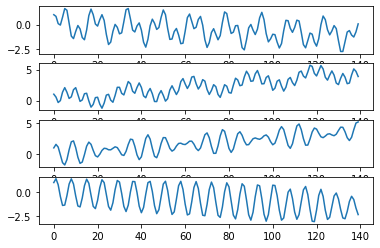

Start step 0; Training for 50000 steps:  90%|███████████████████████▍  | 45007/50000 [21:39<04:23, 18.95it/s, L=0.0783]

72.18392944335938


Start step 0; Training for 50000 steps:  95%|████████████████████████▋ | 47501/50000 [22:50<01:11, 34.97it/s, L=0.0777]

0.01
torch.Size([100, 4, 40])


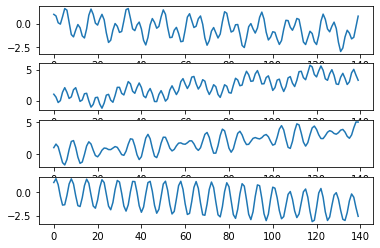

Start step 0; Training for 50000 steps:  95%|████████████████████████▋ | 47507/50000 [22:51<02:11, 18.99it/s, L=0.0605]

Epoch    20: reducing learning rate of group 0 to 5.0000e-03.
72.41922760009766


Start step 0; Training for 50000 steps: 100%|██████████████████████████| 50000/50000 [24:02<00:00, 34.67it/s, L=0.0415]


In [65]:

n_steps=50000
batch_size=32


nchantot=4
trsamp={}
input_size=100
ntime=140
nepoch=n_steps/20
biasvsal=0.05
topred=40
trsamp["train"]=sample(nchantot,biasvsal,input_size,topred)
trsamp["val"]=sample(nchantot,biasvsal,input_size,topred,12229)


modellstm = LSTM(nchan=nchantot,npoint=topred,n_hidden=256,n_layers=1).to('cuda')
modellstm.train()
#modelconv = Conv(nchan=nchantot,npoint=topred).to('cuda')
#modelconv.train()


criterion = nn.MSELoss()

optimizerlstm = torch.optim.Adam(modellstm.parameters(), lr=0.01, weight_decay=0.0)
#optimizerconv = torch.optim.Adam(modelconv.parameters(), lr=0.0003, weight_decay=0.0)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizerlstm, factor=0.5, patience=0, cooldown=4, verbose=True)
fullval=trsamp["val"].sreturn()
valsamp=torch.from_numpy(fullval[0]).to('cuda')
valsamptrue=torch.from_numpy(fullval[1]).to('cuda')


with tqdm(total=n_steps, desc='Start step {}; Training for {} steps'.format(0, n_steps)) as pbar:
        for istep in range(n_steps):
                curtuple = trsamp["train"].sreturn()
                curdata = torch.from_numpy(curtuple[0]).to('cuda')
                #print (curdata.shape)

                #outputsconv  = modelconv(curdata)
                #predchantrue  = outputsconv[0]
                #topass  = outputsconv[1]
                outputs  = modellstm(curdata)
                #print (outputs[0],curtuple[1])

                curtrue = torch.from_numpy(curtuple[1]).to('cuda')

        
                curchantrue = torch.from_numpy(curtuple[2])
                curchantrue=F.one_hot(curchantrue).to('cuda').float()


                curpred = outputs
                #print (curpred.shape )
                #print (curtrue.shape )
                #  curpred=curpred.reshape(curtrue.shape[0],curtrue.shape[1],) 

                #print (torch.std(curtrue-curpred))
                #print (curtrue[0],curpred[0])
                curtrue=curtrue.reshape(curpred.shape)
                #print (curtrue.shape)               
                #print (curpred.shape)               
                loss = criterion(curpred,curtrue).mean()
                

                #lossconv = nn.BCELoss()(predchantrue,curchantrue).mean()

                pbar.set_postfix(L='{:.4f}'.format(loss))
                pbar.update()
                #optimizerconv.zero_grad()
                optimizerlstm.zero_grad()
                
                #lossconv.backward(retain_graph=True)
                loss.backward(retain_graph=False)
                #optimizerconv.step()   
                torch.nn.utils.clip_grad_norm_(modellstm.parameters(), 0.2)
                optimizerlstm.step()

                if (istep%nepoch==0):
                        modellstm.eval()
                        #modelconv.eval()
                        for param_group in optimizerlstm.param_groups:
                                print(param_group["lr"])
                        #for param_group in optimizerconv.param_groups:
                         #       print(param_group["lr"])

                        #outputsconv  = modelconv(valsamp)
                        #predchantrue  = outputsconv[0]
                        #topass  = outputsconv[1]
                        outputs  = modellstm((valsamp))
                        print(outputs.shape)
                        #outputs= outputs.reshape(valsamptrue.shape[0],valsamptrue.shape[1])

                        #print (outputs)
                        #print (valsamptrue) 
                        #print (np.array(xvals).shape)
                        #print (np.array(yvals).shape)
                        plot=True
                        if plot:

                                #plt.clf()
                                fig, axs = plt.subplots(4)
                                axs[0].cla()
                                axs[1].cla()
                                axs[2].cla()
                                axs[3].cla()
                                #plt.plot(np.append(valsamp.cpu().numpy()[0,0,:],outputs.cpu().detach().numpy()[0,0,:]))
                                #plt.plot(np.append(valsamp.cpu().numpy()[0,1,:],outputs.cpu().detach().numpy()[0,1,:]))
                                axs[0].plot(np.append(valsamp.cpu().numpy()[0,0,:],outputs.cpu().detach().numpy()[0,0,:]))
                                axs[1].plot(np.append(valsamp.cpu().numpy()[0,1,:],outputs.cpu().detach().numpy()[0,1,:]))
                                axs[2].plot(np.append(valsamp.cpu().numpy()[0,2,:],outputs.cpu().detach().numpy()[0,2,:]))
                                axs[3].plot(np.append(valsamp.cpu().numpy()[0,3,:],outputs.cpu().detach().numpy()[0,3,:]))
                                #plt.xlabel("steps")
                                #plt.ylabel("position")
                                #plt.title("randdwalk")
                                #plt.show(block=False)
                                #plt.pause(1)
                                plt.show()

                        #sys.exit()
                        validation_loss=criterion(outputs,valsamptrue).mean()*1000
                        scheduler.step(validation_loss)
                        print (validation_loss.tolist())
                        modellstm.train()
                        #modelconv.train()
        
        #plt.close()
